In [51]:
import os
import glob
import numpy as np
import pandas as pd
import json
from PIL import Image
import cv2
import matplotlib.pyplot as plt

### unit function

In [2]:
def rle2mask(rle: str, w, h, transpose=True):
    mask = np.zeros((h*w))
    if not pd.isna(rle):
        rle = rle.split(' ')
        pos = [int(x) for x in rle[0::2]]
        length = [int(x) for x in rle[1::2]]

        for p, l in zip(pos, length):
            mask[p-1:p-1+l] = 1
    
    mask = mask.reshape(h, w)
    if transpose:
        return mask.T
    else: 
        return mask

In [3]:
def mask2rle(mask):
    h, w = mask.shape
    mask_flatten = mask.reshape(-1)
    mask_flatten = np.append(mask_flatten, 0)
    mask_flatten = np.insert(mask_flatten, 0, 0)
    # find start position and end position
    start_pos, *_ = np.where((mask_flatten[1:] - mask_flatten[0:-1]) == 1) # start pos
    start_pos += 1
    end_pos, *_ = np.where((mask_flatten[1:] - mask_flatten[0:-1]) == -1) # end pos
    end_pos += 1
    # calculate length
    length = end_pos - start_pos
    # convert to rle
    rle_list = []
    for p, l in zip(start_pos, length):
        rle_list.append(str(p))
        rle_list.append(str(l))
    rle = ' '.join(rle_list)
    return rle

In [12]:
# def mask2rle(mask):
#     h, w = mask.shape
#     mask_flatten = mask.reshape(-1)
#     # find start position and end position
#     start_pos, *_ = np.where((mask_flatten[1:] - mask_flatten[0:-1]) == 1) # start pos
#     start_pos += 1
#     end_pos, *_ = np.where((mask_flatten[1:] - mask_flatten[0:-1]) == -1) # end pos
#     end_pos += 1
#     # calculate length
#     length = end_pos - start_pos
#     # convert to rle
#     rle_list = []
#     for p, l in zip(start_pos, length):
#         rle_list.append(str(p))
#         rle_list.append(str(l))
#     rle = ' '.join(rle_list)
#     return rle

### Data

In [4]:
root = '/data2/share/hubmap_organ_segmentation'

In [5]:
glob.glob(os.path.join(root, '*'))

['/data2/share/hubmap_organ_segmentation/sample_submission.csv',
 '/data2/share/hubmap_organ_segmentation/patch_1024',
 '/data2/share/hubmap_organ_segmentation/train_images',
 '/data2/share/hubmap_organ_segmentation/train_annotations',
 '/data2/share/hubmap_organ_segmentation/test_images',
 '/data2/share/hubmap_organ_segmentation/train.csv',
 '/data2/share/hubmap_organ_segmentation/patch_data.csv',
 '/data2/share/hubmap_organ_segmentation/patch_512',
 '/data2/share/hubmap_organ_segmentation/test.csv',
 '/data2/share/hubmap_organ_segmentation/patch_data_1024.csv']

In [6]:
sample_df = pd.read_csv(os.path.join(root, 'sample_submission.csv'))
sample_df.head(3)

id    rle
0  10078  12 34

In [7]:
test_df = pd.read_csv(os.path.join(root, 'test.csv'))

In [8]:
test_df

id   organ data_source  img_height  img_width  pixel_size  \
0  10078  spleen      Hubmap        2023       2023      0.4945   

   tissue_thickness  
0                 4

In [9]:
test_df['data_source'].unique()

array(['Hubmap'], dtype=object)

In [10]:
test_imgs = glob.glob(os.path.join(root, 'test_images', '*'))

In [11]:
test_imgs[:5]

['/data2/share/hubmap_organ_segmentation/test_images/10078.tiff']

In [12]:
df = pd.read_csv(os.path.join(root, 'train.csv'))
print(df.shape)
df.head()

(351, 10)


id     organ data_source  img_height  img_width  pixel_size  \
0  10044  prostate         HPA        3000       3000         0.4   
1  10274  prostate         HPA        3000       3000         0.4   
2  10392    spleen         HPA        3000       3000         0.4   
3  10488      lung         HPA        3000       3000         0.4   
4  10610    spleen         HPA        3000       3000         0.4   

   tissue_thickness                                                rle   age  \
0                 4  1459676 77 1462675 82 1465674 87 1468673 92 14...  37.0   
1                 4  715707 2 718705 8 721703 11 724701 18 727692 3...  76.0   
2                 4  1228631 20 1231629 24 1234624 40 1237623 47 12...  82.0   
3                 4  3446519 15 3449517 17 3452514 20 3455510 24 34...  78.0   
4                 4  478925 68 481909 87 484893 105 487863 154 4908...  21.0   

      sex  
0    Male  
1    Male  
2    Male  
3    Male  
4  Female

In [13]:
df['data_source'].unique()

array(['HPA'], dtype=object)

In [14]:
df[['img_height', 'img_width']].drop_duplicates()

img_height  img_width
0          3000       3000
19         2867       2867
29         2654       2654
36         2727       2727
47         2680       2680
51         2539       2539
64         2631       2631
65         2790       2790
83         2942       2942
85         2308       2308
147        2764       2764
181        2783       2783
205        2869       2869
209        2760       2760
211        2630       2630
215        2511       2511
221        2416       2416
310        2593       2593
343        2675       2675
347        3070       3070

In [53]:
df[['organ', 'img_height', 'img_width']].drop_duplicates().sort_values(by='organ')

organ  img_height  img_width
347          kidney        3070       3070
5            kidney        3000       3000
36           kidney        2727       2727
181          kidney        2783       2783
51           kidney        2539       2539
64           kidney        2631       2631
147          kidney        2764       2764
85           kidney        2308       2308
92           kidney        2790       2790
121          kidney        2942       2942
6    largeintestine        3000       3000
3              lung        3000       3000
343            lung        2675       2675
310        prostate        2593       2593
221        prostate        2416       2416
205        prostate        2869       2869
0          prostate        3000       3000
47         prostate        2680       2680
29         prostate        2654       2654
65         prostate        2790       2790
83         prostate        2942       2942
209          spleen        2760       2760
211          spleen        2630       2630
215          spleen        2511       2511
19           spleen        2867       2867
2            spleen        3000       3000

In [15]:
df['data_source'].unique()

array(['HPA'], dtype=object)

In [16]:
# glob.glob(os.path.join(root, 'train_images', '*'))

In [17]:
# glob.glob(os.path.join(root, 'train_anno*', '*'))

In [18]:
# im = Image.open(os.path.join(root, 'train_images', '10044.tiff'))
# im = np.array(im)
im = cv2.imread(os.path.join(root, 'train_images', '10274.tiff'))
print(im.shape)

(3000, 3000, 3)


In [19]:
s = df.query("id == 10274")

im_mask = rle2mask(rle=s['rle'].values[0], w=s['img_width'].values[0], h=s['img_height'].values[0])
print(im_mask.shape)

(3000, 3000)


In [20]:
# 前列腺, 脾臟, 肺, 腎臟, 大腸
df['organ'].unique()

array(['prostate', 'spleen', 'lung', 'kidney', 'largeintestine'],
      dtype=object)

In [21]:
df['organ'].value_counts()

kidney            99
prostate          93
largeintestine    58
spleen            53
lung              48
Name: organ, dtype: int64

183 largeintestine
(3000, 3000, 3)


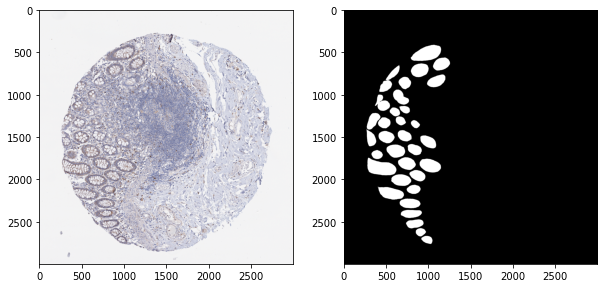

In [23]:
idx = np.random.randint(df.shape[0])

s = df.iloc[idx, :]
print(idx, s['organ'])

im = cv2.imread(os.path.join(root, 'train_images', f"{s['id']}.tiff"))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im_mask = rle2mask(rle=s['rle'], w=s['img_width'], h=s['img_height'])
print(im.shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(im)
ax[1].imshow(im_mask, cmap='gray')
plt.show()

(3000, 3000, 3)


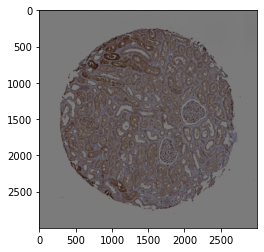

In [50]:
s = df.iloc[246, :]

im = cv2.imread(os.path.join(root, 'train_images', f"{s['id']}.tiff"))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)/255
im = cv2.convertScaleAbs(im*255, alpha=0.5, beta=1.1)
print(im.shape)

plt.imshow(im)
plt.show()

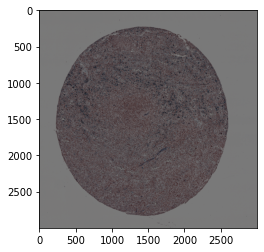

In [58]:
s = df.iloc[126, :]

im = cv2.imread(os.path.join(root, 'train_images', f"{s['id']}.tiff"))
im = cv2.convertScaleAbs(im, alpha=0.5)

plt.imshow(im)
plt.show()

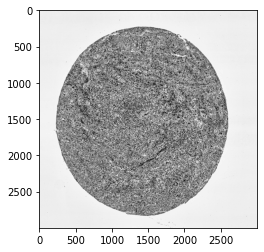

In [238]:
s = df.iloc[126, :]

im = cv2.imread(os.path.join(root, 'train_images', f"{s['id']}.tiff"))
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(im.astype(np.uint8))

plt.imshow(cl1, cmap='gray')
plt.show()

#### create patch data

(3000, 3000, 3)


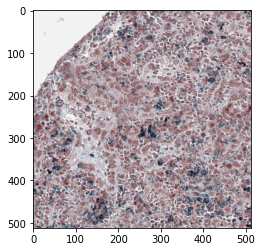

In [129]:
s = df.iloc[126, :]

im = cv2.imread(os.path.join(root, 'train_images', f"{s['id']}.tiff"))
print(im.shape)

plt.imshow(im[500:500+512, 500:500+512, :])
plt.show()

(3000, 3000, 3)


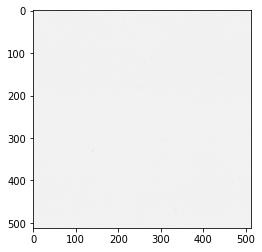

In [126]:
s = df.iloc[126, :]

im = cv2.imread(os.path.join(root, 'train_images', f"{s['id']}.tiff"))
print(im.shape)

# sub patch
sub_im = im[500:500+512, 500:500+512, :]

plt.imshow(im[:512, :512, :])
plt.show()

In [153]:
np.prod(im.shape)

22919088

In [156]:
def check_valid(img, threshold=0.5):
    ratio = (img > 240).sum()/np.prod(img.shape)
    if ratio >= threshold:
        return False
    else:
        return True

In [295]:
3000-1024

1976

In [296]:
np.arange(0, 1976, 512)

array([   0,  512, 1024, 1536])

In [294]:
W = 3000
STEP = 512
PATCH_SIZE = 1024

def gen_patch_idx(w, step, patch_size):
    valid_w = w - patch_size
    start_idx = np.arange(0, valid_w, step)
    end_idx = np.arange(patch_size, w, step)

    if len(start_idx) != len(end_idx):
        start_idx = start_idx[:-1]
        print(w-patch_size)
        start_idx = np.append(start_idx, w-patch_size)
        end_idx = np.append(end_idx, w)
        
    return list(zip(start_idx, end_idx))
    
gen_patch_idx(W, STEP, PATCH_SIZE)

[   0  512 1024 1536 2048 2560] [1024 1536 2048 2560]
1976


[(0, 1024), (512, 1536), (1024, 2048), (1536, 2560), (2048, 3000)]

In [297]:
def gen_patch_idx(w, step, patch_size):
    valid_w = w - patch_size
    start_idx = np.arange(0, valid_w, step)
    return start_idx

gen_patch_idx(W, STEP, PATCH_SIZE)

array([   0,  512, 1024, 1536])

3000 3000
valid:  False


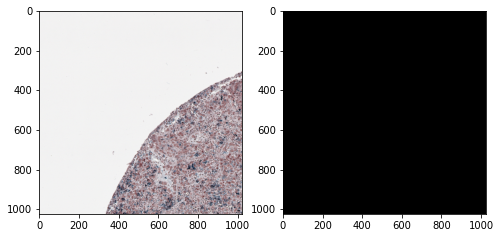

valid:  True


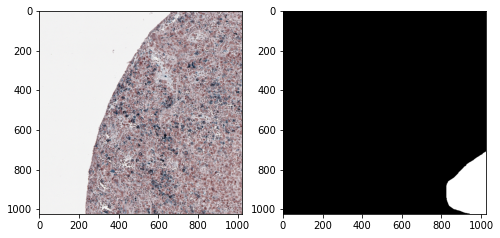

valid:  True


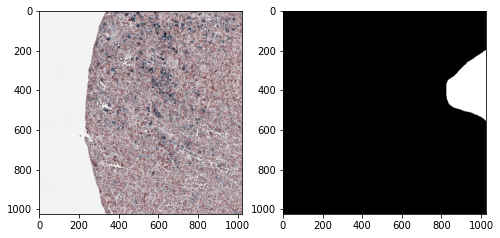

valid:  True


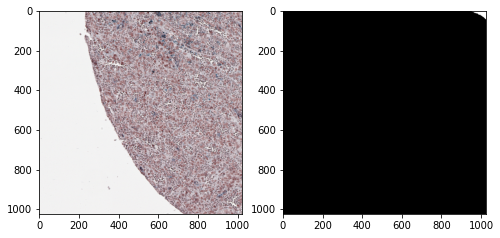

valid:  False


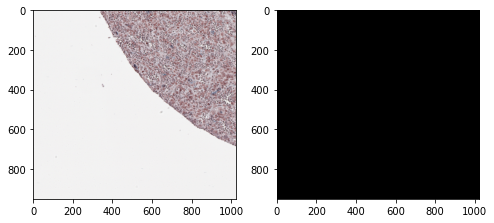

valid:  True


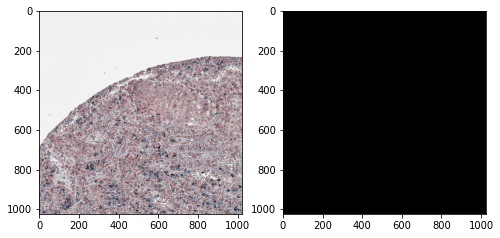

valid:  True


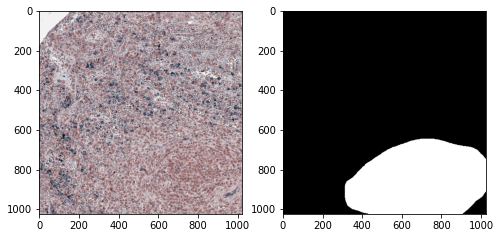

valid:  True


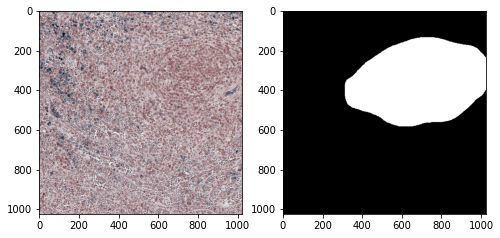

valid:  True


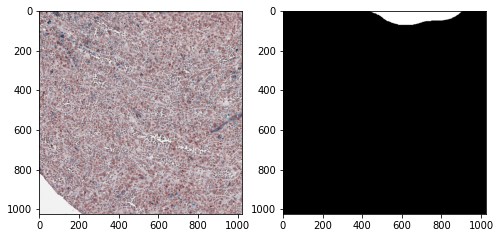

valid:  True


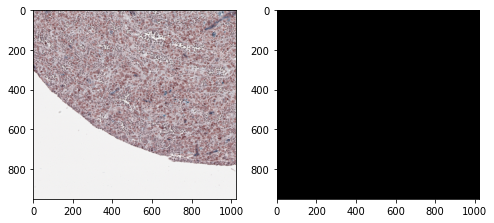

valid:  True


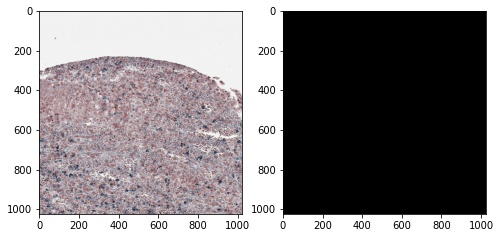

valid:  True


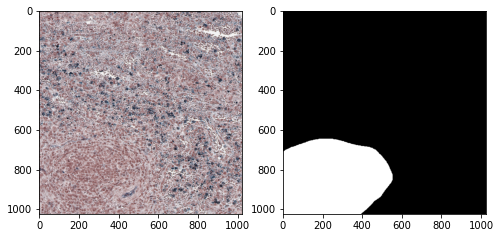

valid:  True


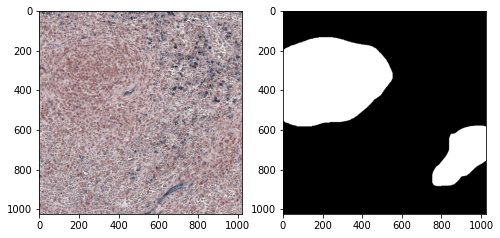

valid:  True


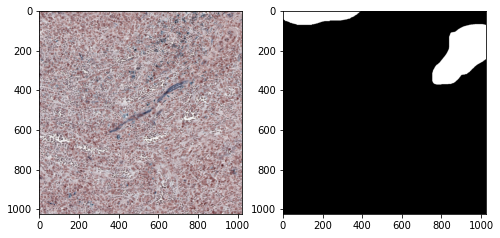

valid:  True


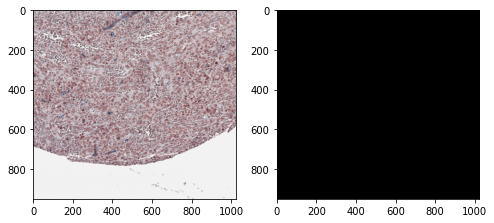

valid:  True


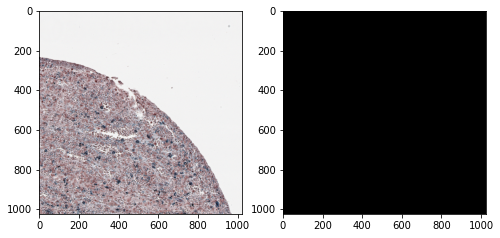

valid:  True


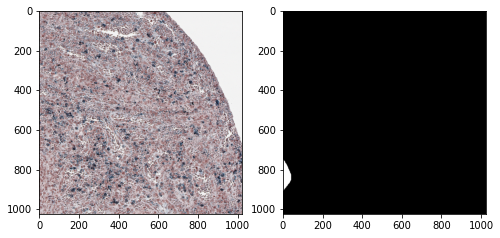

valid:  True


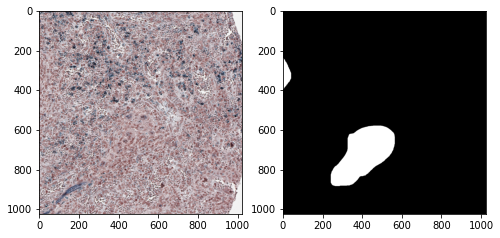

valid:  True


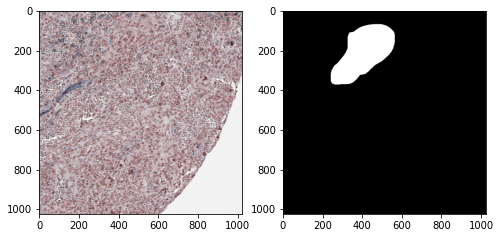

valid:  True


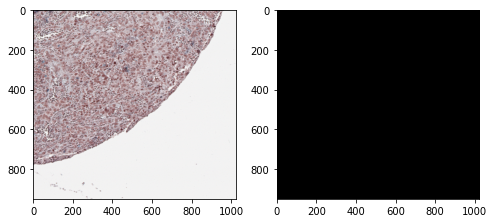

valid:  False


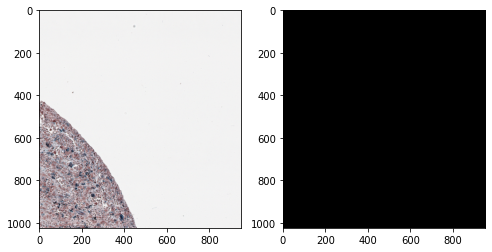

valid:  True


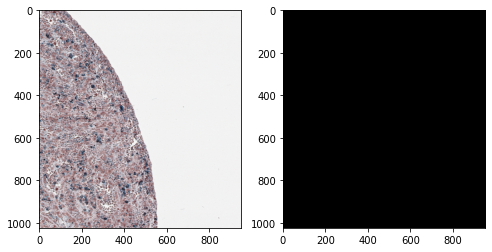

valid:  True


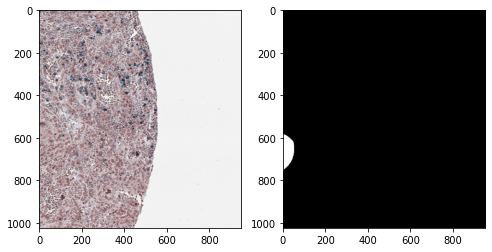

valid:  True


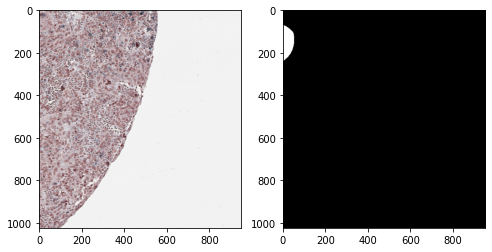

valid:  False


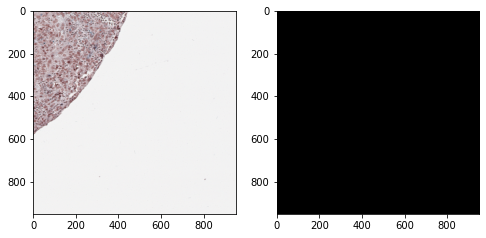

In [241]:
s = df.iloc[126, :]

im = cv2.imread(os.path.join(root, 'train_images', f"{s['id']}.tiff"))
h, w, _ = im.shape
print(h, w)
im_mask = rle2mask(rle=s['rle'], w=w, h=h)


# sub patch
step = 512
patch_size = 1024

start_idx = 0
end_idx = 0 + patch_size

# gen index
w_idx = gen_patch_idx(w, step, patch_size)
h_idx = gen_patch_idx(h, step, patch_size)

for _w_idx in w_idx:
    for _h_idx in h_idx:
        w_start, w_end = _w_idx
        h_start, h_end = _h_idx
        sub_im = im[h_start:h_end, w_start:w_end, :]
        sub_mask = im_mask[h_start:h_end, w_start:w_end]

        valid = check_valid(sub_im, threshold=0.5) or sub_mask.sum() > 0
        print('valid: ', valid)

        fig, ax = plt.subplots(1, 2, figsize=(8, 4))
        ax[0].imshow(sub_im)
        ax[1].imshow(sub_mask, cmap='gray')
        plt.show()

2764 2764
valid:  False


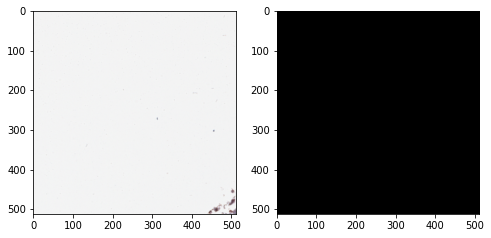

valid:  False


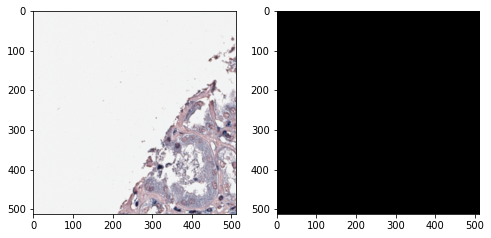

valid:  True


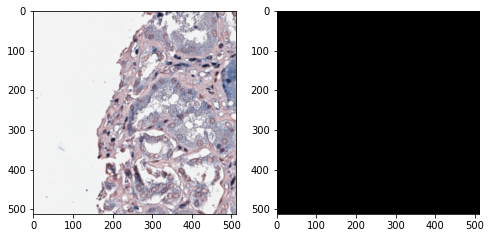

ValueError: operands could not be broadcast together with shapes (98,) (99,) 

In [174]:
s = df.iloc[147, :]

im = cv2.imread(os.path.join(root, 'train_images', f"{s['id']}.tiff"))
h, w, _ = im.shape
print(h, w)
im_mask = rle2mask(rle=s['rle'], w=w, h=h)


# sub patch
step = 512
patch_size = 1024

start_idx = 0
end_idx = 0 + patch_size

# gen index
w_idx = gen_patch_idx(w, step, patch_size)
h_idx = gen_patch_idx(h, step, patch_size)

for _w_idx in w_idx:
    for _h_idx in h_idx:
        w_start, w_end = _w_idx
        h_start, h_end = _h_idx
        sub_im = im[h_start:h_end, w_start:w_end, :]
        sub_mask = im_mask[h_start:h_end, w_start:w_end]
        sub_rle = mask2rle(sub_mask.T)

        valid = check_valid(sub_im, threshold=0.7) or sub_mask.sum() > 0
        print('valid: ', valid)

        fig, ax = plt.subplots(1, 2, figsize=(8, 4))
        ax[0].imshow(sub_im)
        ax[1].imshow(sub_mask, cmap='gray')
        plt.show()

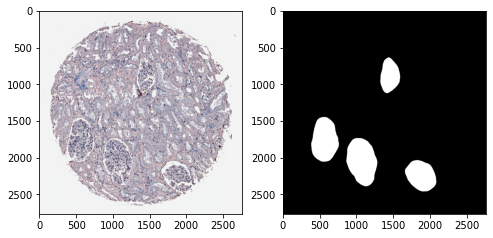

In [197]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(im)
ax[1].imshow(im_mask, cmap='gray')
plt.show()

In [198]:
#  rle = mask2rle(im_mask.T)

In [172]:
df.head()

id     organ data_source  img_height  img_width  pixel_size  \
0  10044  prostate         HPA        3000       3000         0.4   
1  10274  prostate         HPA        3000       3000         0.4   
2  10392    spleen         HPA        3000       3000         0.4   
3  10488      lung         HPA        3000       3000         0.4   
4  10610    spleen         HPA        3000       3000         0.4   

   tissue_thickness                                                rle   age  \
0                 4  1459676 77 1462675 82 1465674 87 1468673 92 14...  37.0   
1                 4  715707 2 718705 8 721703 11 724701 18 727692 3...  76.0   
2                 4  1228631 20 1231629 24 1234624 40 1237623 47 12...  82.0   
3                 4  3446519 15 3449517 17 3452514 20 3455510 24 34...  78.0   
4                 4  478925 68 481909 87 484893 105 487863 154 4908...  21.0   

      sex  
0    Male  
1    Male  
2    Male  
3    Male  
4  Female

In [1]:
df['pixel_size'].unique()

NameError: name 'df' is not defined

In [253]:
np.array([1, 2, 3, 4, 5, 6, 7, 8]).reshape(2, 4)

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [276]:
def mask2rle(mask):
    h, w = mask.shape
    mask_flatten = mask.reshape(-1)
    mask_flatten = np.append(mask_flatten, 0)
    mask_flatten = np.insert(mask_flatten, 0, 0)
    # find start position and end position
    start_pos, *_ = np.where((mask_flatten[1:] - mask_flatten[0:-1]) == 1) # start pos
    start_pos += 1
    end_pos, *_ = np.where((mask_flatten[1:] - mask_flatten[0:-1]) == -1) # end pos
    end_pos += 1
    # calculate length
    length = end_pos - start_pos
    # convert to rle
    rle_list = []
    for p, l in zip(start_pos, length):
        rle_list.append(str(p))
        rle_list.append(str(l))
    rle = ' '.join(rle_list)
    return rle

In [270]:
def rle2mask(rle: str, w, h, transpose=True):
    mask = np.zeros((h*w))
    if not pd.isna(rle):
        rle = rle.split(' ')
        pos = [int(x) for x in rle[0::2]]
        length = [int(x) for x in rle[1::2]]

        for p, l in zip(pos, length):
            mask[p-1:p-1+l] = 1
    
    mask = mask.reshape(h, w)
    if transpose:
        return mask.T
    else: 
        return mask

0 prostate
(3000, 3000, 3)


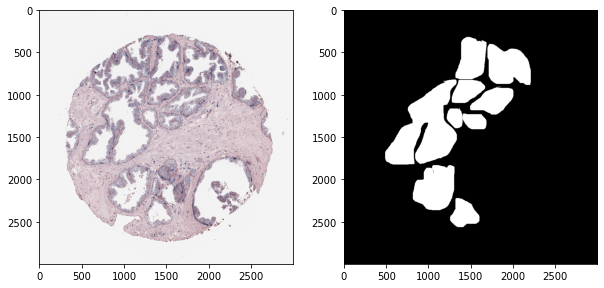

In [280]:
# idx = np.random.randint(df.shape[0])
idx = 0

s = df.iloc[idx, :]
print(idx, s['organ'])

im = cv2.imread(os.path.join(root, 'train_images', f"{s['id']}.tiff"))
im_mask = rle2mask(rle=s['rle'], w=s['img_width'], h=s['img_height'], transpose=True)
# im_mask = cv2.rotate(im_mask, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
print(im.shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(im)
ax[1].imshow(im_mask, cmap='gray')
plt.show()

In [277]:
mask2rle(im_mask.T) == s['rle']

True

In [299]:
# patch df 512*512
id_list = []
patch_num = []
rle_list = []

for i in range(df.shape[0]):
    s = df.iloc[i, :]
    img_id = s['id']

    im = cv2.imread(os.path.join(root, 'train_images', f"{img_id}.tiff"))
    _h, _w, _ = im.shape
    im_mask = rle2mask(rle=s['rle'], w=w, h=h, transpose=True)

    # sub patch
    step = 512
    patch_size = 1024

    start_idx = 0
    end_idx = 0 + patch_size

    # gen index
    w_idx = gen_patch_idx(_w, step, patch_size)
    h_idx = gen_patch_idx(_h, step, patch_size)
    
    p = 0
    for _w_idx in w_idx:
        for _h_idx in h_idx:
            w_start, w_end = _w_idx, _w_idx + patch_size
            h_start, h_end = _h_idx, _h_idx + patch_size
            sub_im = im[h_start:h_end, w_start:w_end, :]
            sub_mask = im_mask[h_start:h_end, w_start:w_end]
            sub_rle = mask2rle(sub_mask.T)

            valid = check_valid(sub_im, threshold=0.65) or sub_mask.sum() > 0
    #         print('valid: ', valid)
            if valid:
                cv2.imwrite(os.path.join(root, 'patch_1024', f"{img_id}_{p}.png"), sub_im)
                id_list.append(img_id)
                patch_num.append(p)
                rle_list.append(sub_rle)
                p += 1
                
#                 _sub_h, _sub_w, _ = sub_im.shape
#                 print(_sub_h, _sub_w)
#                 _sub_mask = rle2mask(sub_rle, _sub_h, _sub_w, transpose=True)
#                 fig, ax = plt.subplots(1, 4, figsize=(16, 4))
#                 ax[0].imshow(sub_im)
#                 ax[1].imshow(sub_mask, cmap='gray')
#                 ax[2].imshow(_sub_mask, cmap='gray')
#                 ax[3].imshow(_sub_mask-sub_mask, cmap='gray')
                
#                 plt.show()

In [300]:
patch_df = pd.DataFrame({
    'id': id_list,
    'patch_num': patch_num,
    'rle': rle_list,
})

In [301]:
patch_df.insert(2, 'img_height', [1024]*patch_df.shape[0])
patch_df.insert(3, 'img_width', [1024]*patch_df.shape[0])

In [302]:
patch_df = patch_df.merge(df[['id', 'organ']], on='id')

In [303]:
patch_df.head()

id  patch_num  img_height  img_width  \
0  10044          0        1024       1024   
1  10044          1        1024       1024   
2  10044          2        1024       1024   
3  10044          3        1024       1024   
4  10044          4        1024       1024   

                                                 rle     organ  
0  963584 1 964608 1 965631 2 966654 3 967677 4 9...  prostate  
1  608256 1 609279 2 610301 4 611324 5 612346 7 6...  prostate  
2  498316 77 499339 82 500362 87 501385 92 502407...  prostate  
3  497804 77 498827 82 499850 87 500873 92 501895...  prostate  
4  439296 1 440320 1 441343 2 442366 3 443389 4 4...  prostate

In [304]:
# patch_df.to_csv(os.path.join(root, 'patch_data_1024.csv'), index=False)